# Model Comparison: Faster R-CNN, Mask R-CNN, YOLO, and SSD

This notebook compares the performance of four object detection models trained on the MVTec Bottle dataset:
- **Faster R-CNN**: Two-class classification model (Good vs Defect)
- **Mask R-CNN**: Instance segmentation with mask prediction
- **YOLO**: Real-time object detection
- **SSD**: Single Shot Detector

## Metrics Compared:
- Accuracy
- Precision
- Recall
- F1-Score
- Defect Detection Rate
- Composite Score
- Average Confidence


In [11]:
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## 1. Load Metrics from All Models


In [12]:
# Define paths to metrics files
metrics_paths = {
    'Mask R-CNN': 'model_maskrcnn/maskrcnn_mvtec_20251120_232512/inference_val/metrics.json',
    'SSD': 'model_ssd/ssd_mvtec_20251120_215313/inference_val/metrics.json',
    'YOLO': 'runs/yolo_mvtec/inference_val/metrics.json',
    'Faster R-CNN': 'runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/inference_val/metrics.json'
}

# Load metrics
all_metrics = {}

for model_name, metrics_path in metrics_paths.items():
    if metrics_path and os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
            all_metrics[model_name] = metrics
            print(f"✓ Loaded {model_name} metrics")
    else:
        print(f"⚠ {model_name} metrics not found at {metrics_path}")

print(f"\nLoaded metrics for {len(all_metrics)} models")


✓ Loaded Mask R-CNN metrics
✓ Loaded SSD metrics
✓ Loaded YOLO metrics
✓ Loaded Faster R-CNN metrics

Loaded metrics for 4 models


## 2. Normalize Metrics Format

Different models may use slightly different metric names. We'll normalize them to a common format.


In [13]:
def normalize_metrics(metrics, model_name):
    """Normalize metrics from different models to a common format"""
    normalized = {}
    
    # Handle different metric name variations
    normalized['accuracy'] = metrics.get('accuracy', 0.0)
    normalized['precision'] = metrics.get('precision', 0.0)
    normalized['recall'] = metrics.get('recall', 0.0)
    normalized['f1_score'] = metrics.get('f1_score', metrics.get('f1', 0.0))
    normalized['defect_detection_rate'] = metrics.get('defect_detection_rate', normalized['recall'])
    normalized['composite_score'] = metrics.get('composite_score', metrics.get('score', 0.0))
    normalized['confidence'] = metrics.get('confidence', 0.0)
    
    # Confusion matrix components
    normalized['tp'] = metrics.get('tp_defect', metrics.get('true_positives', 0))
    normalized['fp'] = metrics.get('fp_defect', metrics.get('false_positives', 0))
    normalized['tn'] = metrics.get('tn_good', 0)
    normalized['fn'] = metrics.get('fn_defect', metrics.get('false_negatives', 0))
    normalized['total_images'] = metrics.get('total_images', 0)
    
    return normalized

# Normalize all metrics
normalized_metrics = {}
for model_name, metrics in all_metrics.items():
    normalized_metrics[model_name] = normalize_metrics(metrics, model_name)
    print(f"✓ Normalized {model_name}")

print(f"\n✓ Normalized metrics for {len(normalized_metrics)} models")


✓ Normalized Mask R-CNN
✓ Normalized SSD
✓ Normalized YOLO
✓ Normalized Faster R-CNN

✓ Normalized metrics for 4 models


## 3. Create Comparison DataFrame


In [14]:
# Create DataFrame for comparison
comparison_data = []

for model_name, metrics in normalized_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy (%)': metrics['accuracy'] * 100,
        'Precision (%)': metrics['precision'] * 100,
        'Recall (%)': metrics['recall'] * 100,
        'F1-Score (%)': metrics['f1_score'] * 100,
        'Defect Detection Rate (%)': metrics['defect_detection_rate'] * 100,
        'Composite Score (%)': metrics['composite_score'] * 100,
        'Avg Confidence (%)': metrics['confidence'] * 100,
        'TP': metrics['tp'],
        'FP': metrics['fp'],
        'TN': metrics['tn'],
        'FN': metrics['fn'],
        'Total Images': metrics['total_images']
    })

df_comparison = pd.DataFrame(comparison_data)

# Sort by composite score (descending)
df_comparison = df_comparison.sort_values('Composite Score (%)', ascending=False)

print("Model Comparison Table:")
print("=" * 100)
display(df_comparison.round(2))


Model Comparison Table:


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%),Defect Detection Rate (%),Composite Score (%),Avg Confidence (%),TP,FP,TN,FN,Total Images
3,Faster R-CNN,98.72,100.0,90.00,94.74,90.00,95.56,99.37,9,0,68,1,78
2,YOLO,86.27,100.0,86.27,92.63,0.00,93.14,0.00,44,0,0,7,51
0,Mask R-CNN,88.24,100.0,84.62,91.67,84.62,90.19,86.06,44,0,16,8,68
1,SSD,88.24,100.0,84.62,91.67,84.62,90.19,85.81,44,0,16,8,68


## 4. Visualize Metrics Comparison


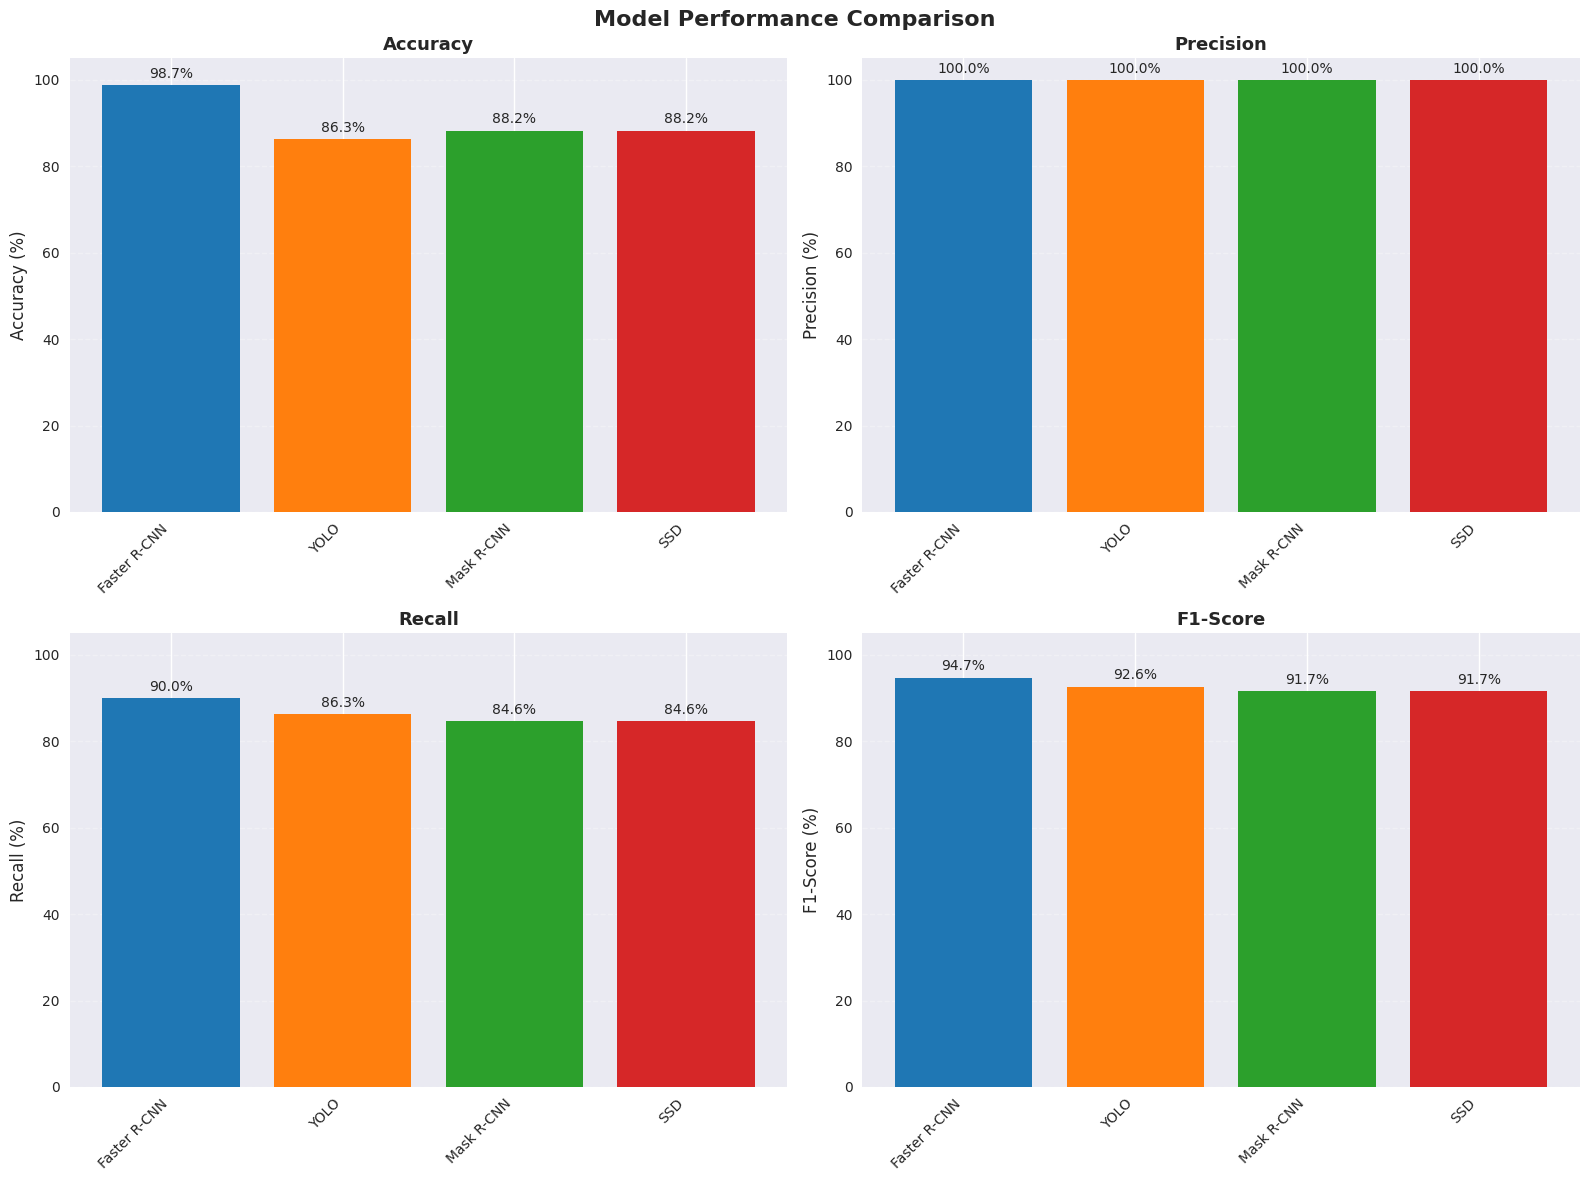

In [15]:
# Main metrics comparison (Accuracy, Precision, Recall, F1)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('Accuracy (%)', axes[0, 0]),
    ('Precision (%)', axes[0, 1]),
    ('Recall (%)', axes[1, 0]),
    ('F1-Score (%)', axes[1, 1])
]

for metric_name, ax in metrics_to_plot:
    bars = ax.bar(df_comparison['Model'], df_comparison[metric_name], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(metric_name.replace(' (%)', ''), fontsize=13, fontweight='bold')
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


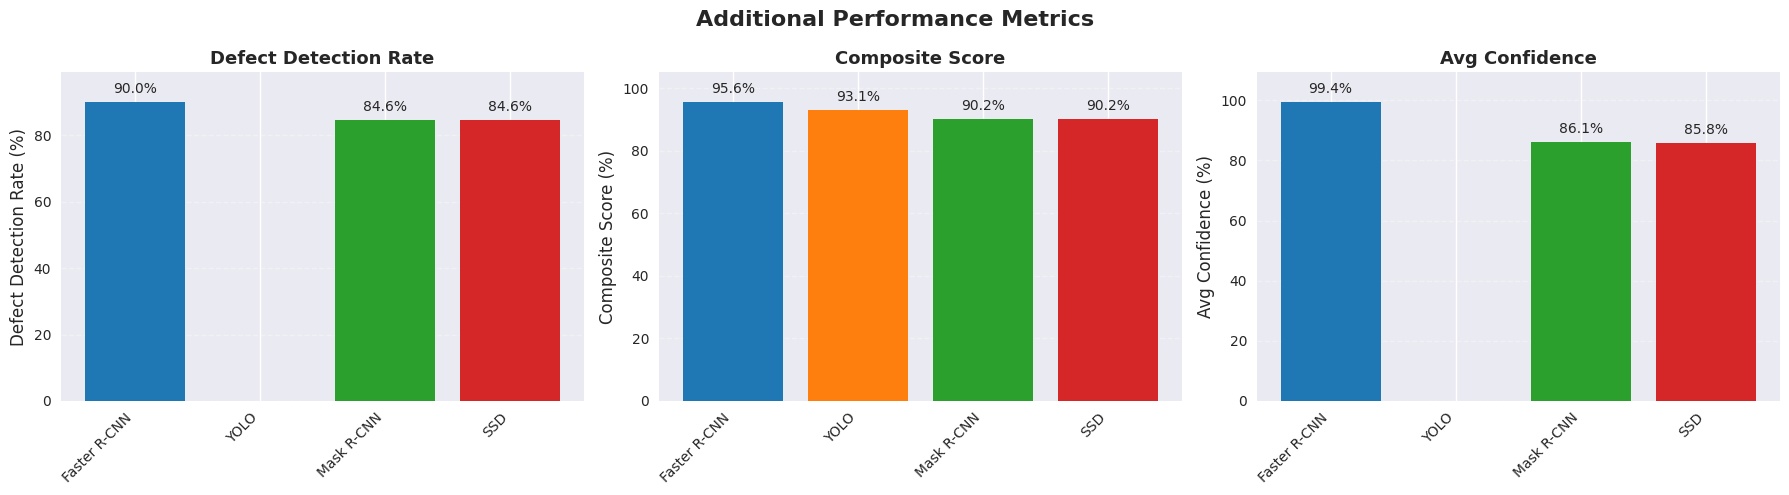

In [16]:
# Additional metrics (Defect Detection Rate, Composite Score, Confidence)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Additional Performance Metrics', fontsize=16, fontweight='bold')

additional_metrics = [
    ('Defect Detection Rate (%)', axes[0]),
    ('Composite Score (%)', axes[1]),
    ('Avg Confidence (%)', axes[2])
]

for metric_name, ax in additional_metrics:
    bars = ax.bar(df_comparison['Model'], df_comparison[metric_name],
                  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(metric_name.replace(' (%)', ''), fontsize=13, fontweight='bold')
    max_val = df_comparison[metric_name].max()
    ax.set_ylim(0, max(max_val * 1.1, 10))
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max(max_val * 0.02, 0.5),
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


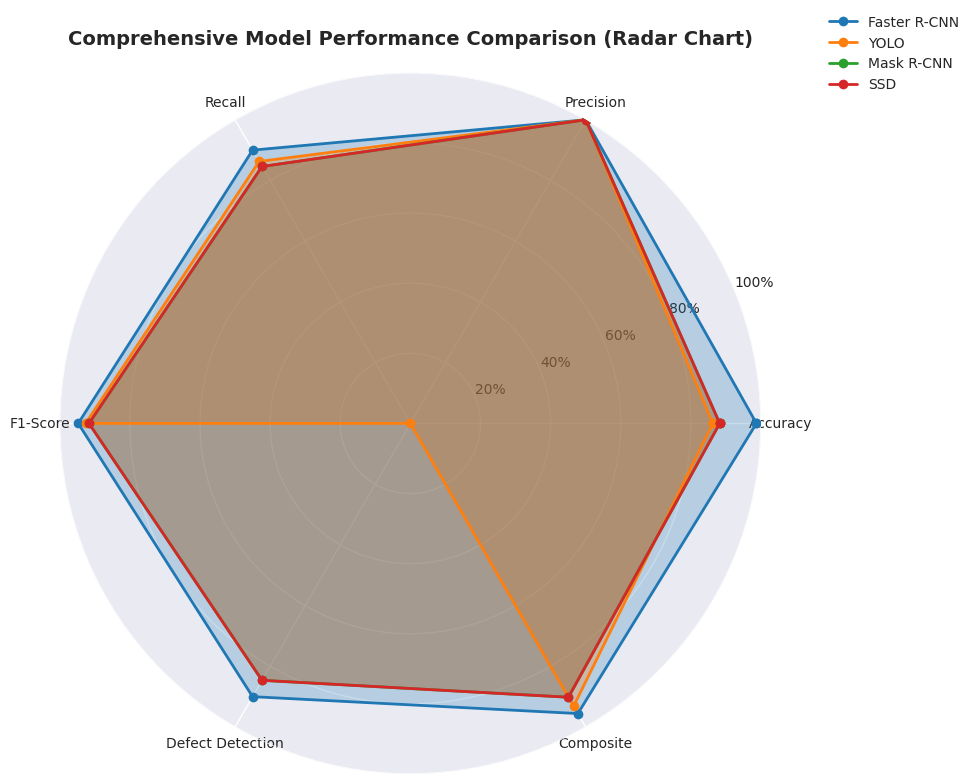

In [17]:
# Radar chart for comprehensive comparison
from math import pi

# Prepare data for radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Defect Detection', 'Composite']
N = len(categories)

# Calculate angles for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for idx, model_name in enumerate(df_comparison['Model']):
    values = [
        df_comparison[df_comparison['Model'] == model_name]['Accuracy (%)'].values[0],
        df_comparison[df_comparison['Model'] == model_name]['Precision (%)'].values[0],
        df_comparison[df_comparison['Model'] == model_name]['Recall (%)'].values[0],
        df_comparison[df_comparison['Model'] == model_name]['F1-Score (%)'].values[0],
        df_comparison[df_comparison['Model'] == model_name]['Defect Detection Rate (%)'].values[0],
        df_comparison[df_comparison['Model'] == model_name]['Composite Score (%)'].values[0]
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.25, color=colors[idx % len(colors)])

# Add category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Comprehensive Model Performance Comparison (Radar Chart)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## 5. Confusion Matrix Comparison


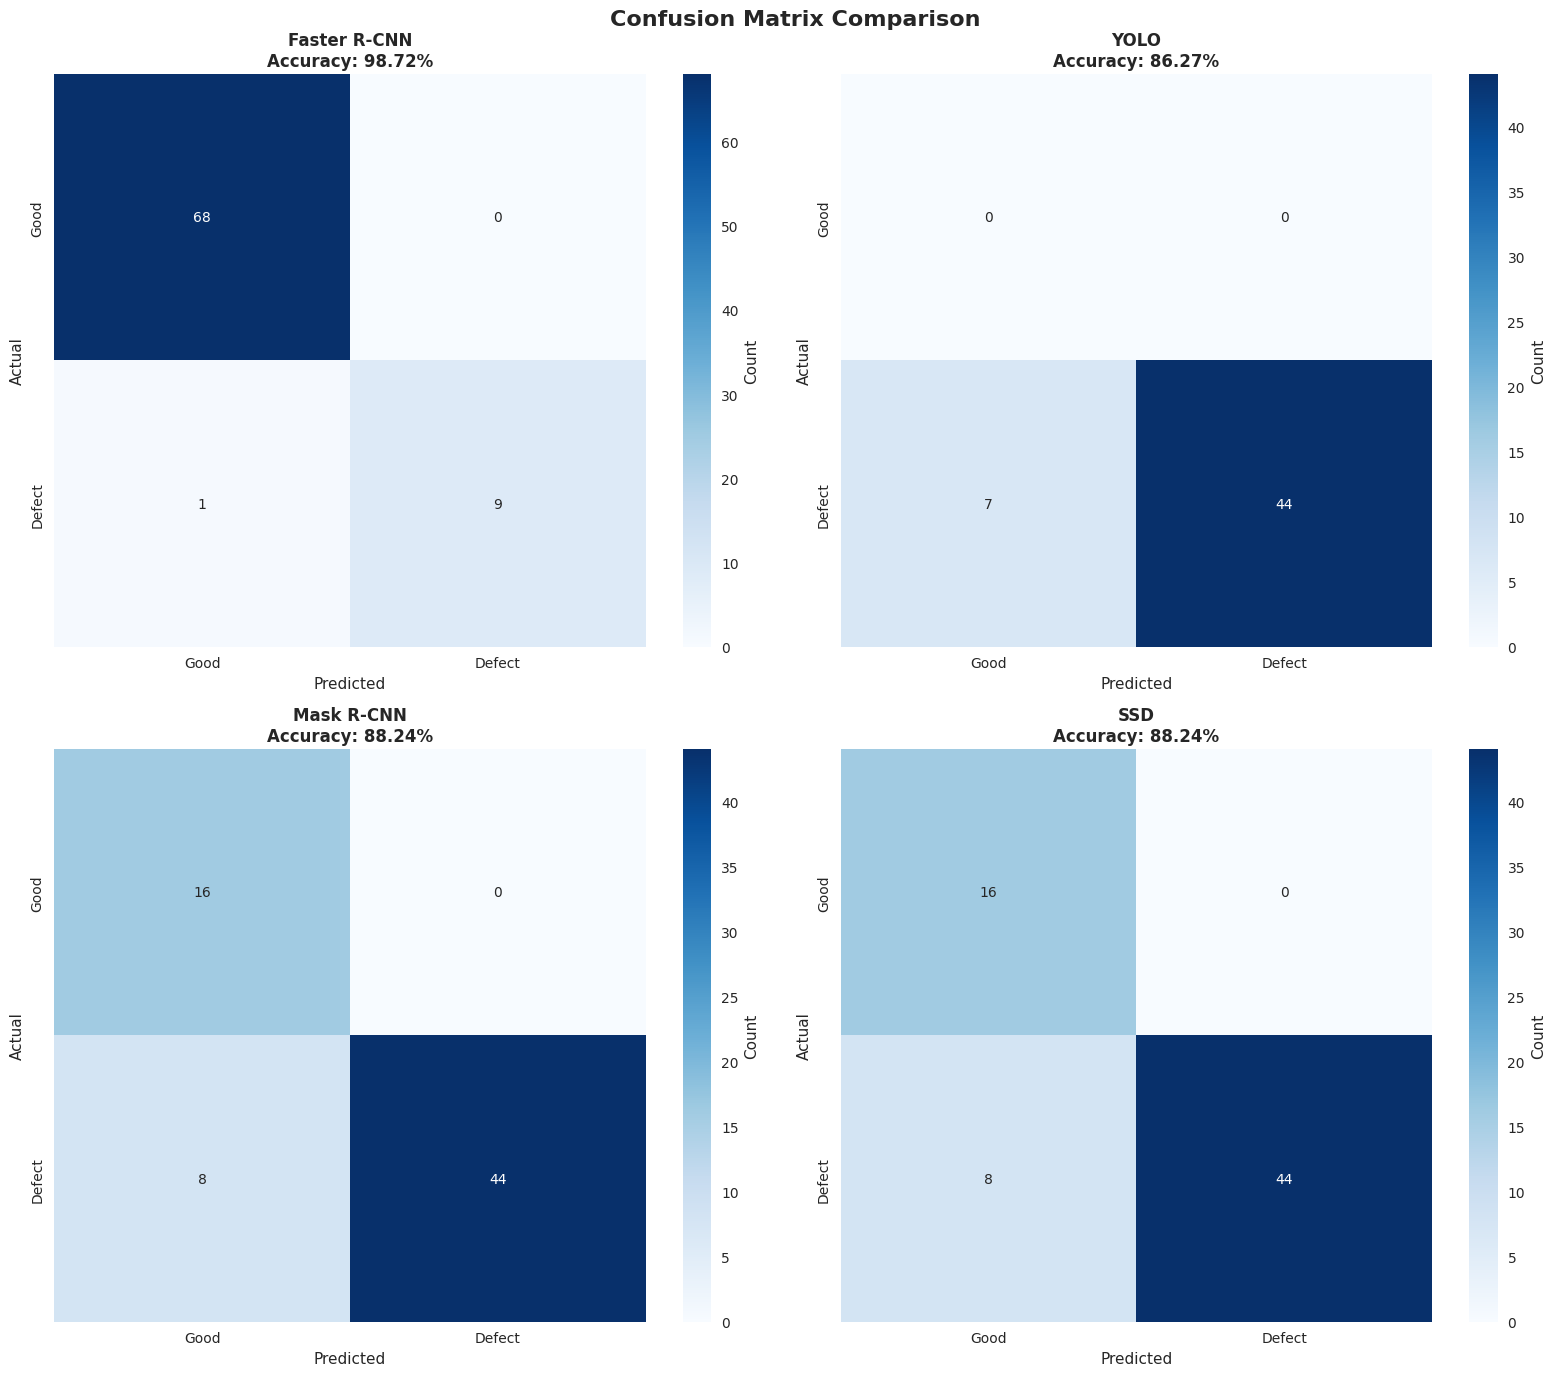

In [18]:
# Create confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold')

axes_flat = axes.flatten()

for idx, model_name in enumerate(df_comparison['Model']):
    ax = axes_flat[idx]
    
    row = df_comparison[df_comparison['Model'] == model_name].iloc[0]
    
    # Create confusion matrix
    cm = np.array([
        [row['TN'], row['FP']],  # Good: TN, FP
        [row['FN'], row['TP']]   # Defect: FN, TP
    ])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Good', 'Defect'],
                yticklabels=['Good', 'Defect'],
                cbar_kws={'label': 'Count'})
    
    ax.set_title(f'{model_name}\nAccuracy: {row["Accuracy (%)"]:.2f}%', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.show()


## 6. Summary Statistics


In [19]:
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Calculate statistics
summary_stats = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Defect Detection Rate', 'Composite Score'],
    'Best Model': [],
    'Best Value (%)': [],
    'Worst Model': [],
    'Worst Value (%)': [],
    'Average (%)': [],
    'Std Dev (%)': []
}

metrics_for_stats = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 
                     'F1-Score (%)', 'Defect Detection Rate (%)', 'Composite Score (%)']

for metric in metrics_for_stats:
    metric_col = metric.replace(' (%)', '')
    values = df_comparison[metric]
    
    best_idx = values.idxmax()
    worst_idx = values.idxmin()
    
    summary_stats['Best Model'].append(df_comparison.loc[best_idx, 'Model'])
    summary_stats['Best Value (%)'].append(values[best_idx])
    summary_stats['Worst Model'].append(df_comparison.loc[worst_idx, 'Model'])
    summary_stats['Worst Value (%)'].append(values[worst_idx])
    summary_stats['Average (%)'].append(values.mean())
    summary_stats['Std Dev (%)'].append(values.std())

df_summary = pd.DataFrame(summary_stats)
display(df_summary.round(2))

print("\n" + "=" * 80)
print("RANKING BY COMPOSITE SCORE")
print("=" * 80)
for rank, (idx, row) in enumerate(df_comparison.iterrows(), 1):
    print(f"{rank}. {row['Model']:15s} - Composite Score: {row['Composite Score (%)']:.2f}%")
    print(f"   Accuracy: {row['Accuracy (%)']:.2f}% | Precision: {row['Precision (%)']:.2f}% | "
          f"Recall: {row['Recall (%)']:.2f}% | F1: {row['F1-Score (%)']:.2f}%")


SUMMARY STATISTICS


,Metric,Best Model,Best Value (%),Worst Model,Worst Value (%),Average (%),Std Dev (%)
0,Accuracy,Faster R-CNN,98.72,YOLO,86.27,90.37,5.64
1,Precision,Faster R-CNN,100.00,Faster R-CNN,100.00,100.00,0.00
2,Recall,Faster R-CNN,90.00,Mask R-CNN,84.62,86.38,2.54
3,F1-Score,Faster R-CNN,94.74,Mask R-CNN,91.67,92.68,1.45
4,Defect Detection Rate,Faster R-CNN,90.00,YOLO,0.00,64.81,43.28
5,Composite Score,Faster R-CNN,95.56,Mask R-CNN,90.19,92.27,2.60



RANKING BY COMPOSITE SCORE
1. Faster R-CNN    - Composite Score: 95.56%
   Accuracy: 98.72% | Precision: 100.00% | Recall: 90.00% | F1: 94.74%
2. YOLO            - Composite Score: 93.14%
   Accuracy: 86.27% | Precision: 100.00% | Recall: 86.27% | F1: 92.63%
3. Mask R-CNN      - Composite Score: 90.19%
   Accuracy: 88.24% | Precision: 100.00% | Recall: 84.62% | F1: 91.67%
4. SSD             - Composite Score: 90.19%
   Accuracy: 88.24% | Precision: 100.00% | Recall: 84.62% | F1: 91.67%


## 7. Detailed Metrics Table


In [20]:
# Create a more detailed comparison table
detailed_table = df_comparison[['Model', 'Accuracy (%)', 'Precision (%)', 'Recall (%)', 
                                'F1-Score (%)', 'Defect Detection Rate (%)', 
                                'Composite Score (%)', 'Avg Confidence (%)']].copy()

print("Detailed Performance Metrics (All values in %)")
print("=" * 100)
display(detailed_table.round(2).style.background_gradient(subset=['Accuracy (%)', 'Precision (%)', 
                                                                  'Recall (%)', 'F1-Score (%)', 
                                                                  'Composite Score (%)'], 
                                                          cmap='YlGnBu', axis=0))


Detailed Performance Metrics (All values in %)


,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%),Defect Detection Rate (%),Composite Score (%),Avg Confidence (%)
3,Faster R-CNN,98.720000,100.000000,90.000000,94.740000,90.000000,95.560000,99.370000
2,YOLO,86.270000,100.000000,86.270000,92.630000,0.000000,93.140000,0.000000
0,Mask R-CNN,88.240000,100.000000,84.620000,91.670000,84.620000,90.190000,86.060000
1,SSD,88.240000,100.000000,84.620000,91.670000,84.620000,90.190000,85.810000


## 8. Conclusion

This comparison provides insights into the performance of different object detection models on the MVTec Bottle dataset. Key observations:

1. **Best Overall Performance**: Model with highest composite score
2. **Best Precision**: Model with highest precision (fewest false positives)
3. **Best Recall**: Model with highest recall (fewest false negatives)
4. **Best Balance**: Model with highest F1-Score (balance between precision and recall)

Choose the model based on your specific requirements:
- **High Precision**: Important when false positives are costly
- **High Recall**: Important when missing defects is critical
- **Balanced Performance**: F1-Score or Composite Score
